Необходимо решить задачу классификации для определения направления движения экзоскелета.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
import time
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
col_names = ['time', 'emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5', 'emg_6', 'pot_1', 'pot_2', 'pot_3']
data_ = pd.read_csv('/content/drive/MyDrive/Vlad_data.csv', sep=';', header=None, names=col_names)

Датасет состоит из набора ЭМГ сигналов с 6 датчиков и набора сигналов с датчиков положения с 3 датчиков. Для классификации используются стобцы emg_1 и emg_6, остальные ЭМГ являются шумом.

In [15]:
data_.head()

,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,pot_1,pot_2,pot_3
0,-3.333027,-0.290417,-0.290417,-0.290417,-0.290417,-0.295146,-5.672133,0.674031,-20.165807
1,-0.290355,-0.290417,-0.290417,-0.290417,-0.290417,-0.295146,-5.598286,0.505117,-17.443197
2,-0.290355,-0.290417,-0.290417,-0.290417,-0.290417,-0.295146,-5.524994,0.336202,-15.004191
3,0.144798,0.144767,0.144767,0.144767,0.144767,-0.295146,-5.452256,0.448812,-12.792070
4,0.144798,0.144767,0.144767,0.144767,0.144767,-0.295146,-5.380073,0.279898,-10.806833


Убираем столбец со временем, так как его не используем:

In [4]:
data_ = data_.drop('time', axis=1)

Нормализация сигналов:

In [5]:
mean = data_.mean()
std = data_.std()
data_ = (data_ - mean) / std

In [6]:
len(data_)

154751

Проверка времени выполнения Savitzky–Golay filter для сглаживания сигналов положения руки:

In [8]:
from scipy.signal import savgol_filter, cwt, ricker
%time
savgol_filter(data_['pot_1'], 5, 2)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


array([-14.90777074, -13.54389442, -12.30480165, ...,   0.48352586,
         0.48352586,   0.48352586])

Проверка применимости вейвлет-преобразования для ЭМГ-сигналов:

In [9]:
a = cwt(data=data_['emg_1'], wavelet=ricker, widths=np.arange(1, 30))

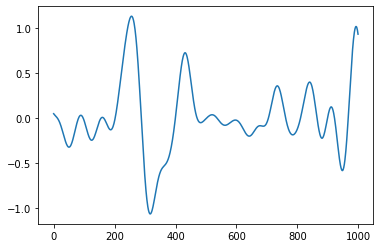

In [10]:
plt.plot(a[-1][1000:2000])

Применение фильтра для сигналов положения:

In [13]:
data_['pot_1'] = savgol_filter(data_['pot_1'], 201, 2)

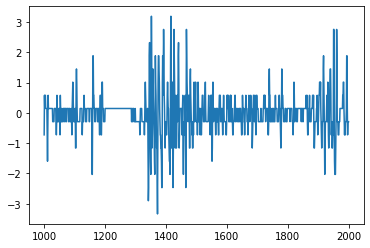

In [14]:
plt.plot(data_['emg_1'][1000:2000])

Применение вейвлет-преобразования для ЭМГ-сигналов:

In [16]:
# data_['emg_1_new'] = savgol_filter(data_['emg_1'], 201, 2)
# data_['emg_6_new'] = savgol_filter(data_['emg_6'], 201, 2)
data_['emg_1_new'] = cwt(data=data_['emg_1'], wavelet=ricker, widths=np.arange(1, 30))[-1]
data_['emg_6_new'] = cwt(data=data_['emg_6'], wavelet=ricker, widths=np.arange(1, 30))[-1]

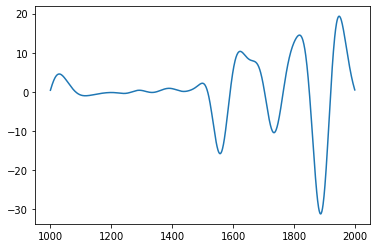

In [17]:
plt.plot(data_['emg_6_new'][1000:2000])

Вычисление прозводной, которую и необходимо предсказать. Используется разностная схема на 6 точках, далее применяется аналог функции sign: 

In [18]:
grad = []
for i in range(3, len(data_) - 3):
    grad.append((-data_['pot_1'][i - 3] + 9*data_['pot_1'][i - 2] - 45*data_['pot_1'][i - 1] + 45*data_['pot_1'][i + 1] - 9*data_['pot_1'][i + 2] + data_['pot_1'][i + 3]) / 60)
print(len(grad))

154745


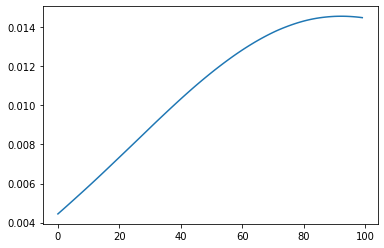

In [19]:
plt.plot(grad[3000:3100])

In [20]:
grad.extend([0] * 6)

In [21]:
my_sign = []
eps = 0.0003
for i in range(len(grad)):
    if -eps < grad[i] < eps:
        my_sign.append(0)
    elif grad[i] > eps:
        my_sign.append(1)
    else:
        my_sign.append(2)

In [22]:
data_['grad'] = my_sign

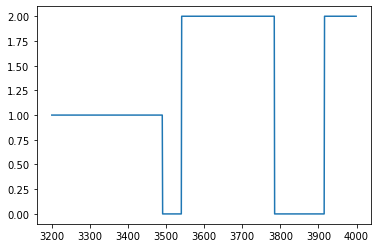

In [23]:
plt.plot(data_['grad'][3200:4000])

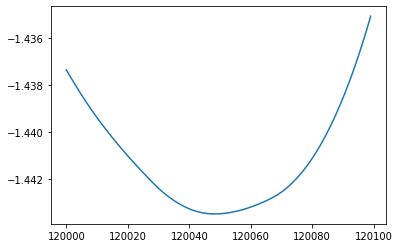

In [24]:
plt.plot(data_['pot_1'][120000:120100])

Распределение целевой переменной:

In [25]:
data_['grad'].value_counts()

2    65154
1    57405
0    32192
Name: grad, dtype: int64

In [26]:
data_

,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,pot_1,pot_2,pot_3,emg_1_new,emg_6_new,grad
0,-3.333027,-0.290417,-0.290417,-0.290417,-0.290417,-0.295146,-5.672133,0.674031,-20.165807,-0.599779,-0.029890,1
1,-0.290355,-0.290417,-0.290417,-0.290417,-0.290417,-0.295146,-5.598286,0.505117,-17.443197,-0.581732,-0.070058,1
2,-0.290355,-0.290417,-0.290417,-0.290417,-0.290417,-0.295146,-5.524994,0.336202,-15.004191,-0.561629,-0.109813,1
3,0.144798,0.144767,0.144767,0.144767,0.144767,-0.295146,-5.452256,0.448812,-12.792070,-0.539558,-0.149012,1
4,0.144798,0.144767,0.144767,0.144767,0.144767,-0.295146,-5.380073,0.279898,-10.806833,-0.515616,-0.187520,1
...,...,...,...,...,...,...,...,...,...,...,...,...
154746,-0.290355,-0.290417,-0.290417,-0.290417,-0.290417,0.440738,0.485050,1.462297,0.991146,-0.109193,0.109317,0
154747,0.144798,0.144767,0.144767,0.144767,0.144767,0.440738,0.484969,1.518602,0.991146,-0.100555,0.088617,0
154748,0.144798,0.144767,0.144767,0.144767,0.144767,0.440738,0.484889,1.631211,0.991146,-0.091503,0.066898,0
154749,0.579951,0.579950,0.579950,0.579950,0.579950,0.440738,0.484810,1.462297,0.991146,-0.082096,0.044212,0


In [27]:
X = data_[['emg_1_new', 'emg_6_new']].values
y = data_['grad'].values

In [28]:
X

array([[-0.5997794 , -0.02988958],
       [-0.58173179, -0.07005841],
       [-0.56162949, -0.10981266],
       ...,
       [-0.09150264,  0.06689796],
       [-0.08209557,  0.04421242],
       [-0.07238233,  0.02058821]])

Разбиение набора данных на train и test:

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69, shuffle=False)

Перевод данных в тензоры:

In [30]:
X_train, X_test = torch.Tensor(X_train), torch.Tensor(X_test)
y_train, y_test = torch.LongTensor(y_train), torch.LongTensor(y_test)

In [31]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [32]:
epochs = 10
batch_size = 50
lr = 0.001
num_features = 2
num_classes = 3

In [33]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Обучение сверточной нейросети

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 6, 1)
        self.pool = nn.MaxPool1d(1, 1)
        self.conv2 = nn.Conv1d(6, 16, 1)
        self.fc1 = nn.Linear(32, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 3)

    def forward(self, x):
        # print(x.shape)
        x = self.conv1(x)
        # print(x.shape)
        x = self.pool(F.relu(x))
        x = self.pool(F.relu(self.conv2(x)))
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = x.view(-1, 32)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
model = CNN()
# model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)

CNN(
  (conv1): Conv1d(1, 6, kernel_size=(1,), stride=(1,))
  (pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(6, 16, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
)


In [ ]:
for x, y in train_loader:
    print(torch.unsqueeze(x, 1).shape)
    break

torch.Size([50, 1, 2])


In [ ]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(torch.unsqueeze(inputs, 1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.029
[2,  2000] loss: 1.017
[3,  2000] loss: 1.003
[4,  2000] loss: 1.005
[5,  2000] loss: 1.012
[6,  2000] loss: 1.014
[7,  2000] loss: 1.012
[8,  2000] loss: 1.013
[9,  2000] loss: 1.009
[10,  2000] loss: 1.013
Finished Training


In [ ]:
correct = 0
total = 0
preds = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        # calculate outputs by running images through the network
        outputs = model(torch.unsqueeze(inputs, 1))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        preds.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [ ]:
flat_list = [item for sublist in preds for item in sublist]

In [ ]:
flat_list = np.array(flat_list)
flat_list[flat_list == 2] = -1

Предсказание:

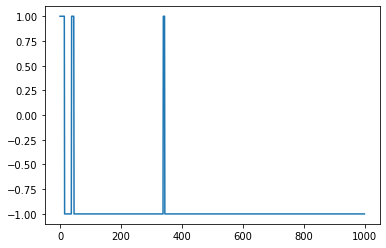

In [ ]:
plt.plot(flat_list[3000:4000])

In [ ]:
y_test = np.array(y_test)
y_test[y_test == 2] = -1

Тестовые данные:

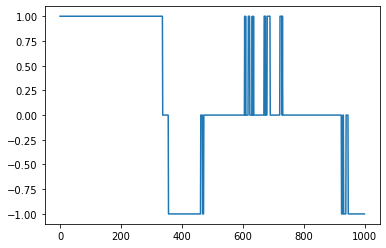

In [ ]:
plt.plot(y_test[3000:4000])

# Обучение полносвязной нейросети

In [ ]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        # print(x.shape)
        
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
model = MulticlassClassification(num_feature = num_features, num_class=num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
)


In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [ ]:
print("Begin training.")
for e in tqdm.notebook.tqdm(range(1, epochs+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch[:, 0:2])
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch[:, 0:2])
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(test_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(test_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(test_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(test_loader):.3f}')

Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.03344 | Val Loss: 0.53749 | Train Acc: 42.280| Val Acc: 15.577
Epoch 002: | Train Loss: 1.02707 | Val Loss: 0.54423 | Train Acc: 42.497| Val Acc: 14.547
Epoch 003: | Train Loss: 1.03027 | Val Loss: 0.52767 | Train Acc: 42.047| Val Acc: 14.729
Epoch 004: | Train Loss: 1.03264 | Val Loss: 0.50706 | Train Acc: 41.801| Val Acc: 14.519
Epoch 005: | Train Loss: 1.03299 | Val Loss: 0.50086 | Train Acc: 41.974| Val Acc: 14.661
Epoch 006: | Train Loss: 1.03271 | Val Loss: 0.52688 | Train Acc: 42.059| Val Acc: 14.794
Epoch 007: | Train Loss: 1.03178 | Val Loss: 0.53378 | Train Acc: 42.231| Val Acc: 14.535
Epoch 008: | Train Loss: 1.03108 | Val Loss: 0.50647 | Train Acc: 42.348| Val Acc: 14.748
Epoch 009: | Train Loss: 1.03057 | Val Loss: 0.48730 | Train Acc: 42.930| Val Acc: 14.571
Epoch 010: | Train Loss: 1.03126 | Val Loss: 0.52014 | Train Acc: 43.006| Val Acc: 15.042


In [ ]:
y_pred_list = []
traj = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch[:, 0:2])
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        traj.append(X_batch[:, 2].tolist())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
traj = [item for sublist in traj for item in sublist]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
flat_list = [item for sublist in y_pred_list[:-1] for item in sublist]

In [ ]:
flat_list.append(y_pred_list[-1])

In [ ]:
len(flat_list)

30951

In [ ]:
# y_test.tolist()

In [ ]:
flat_list = np.array(flat_list)
flat_list[flat_list == 2] = -1

In [ ]:
y_test = np.array(y_test)
y_test[y_test == 2] = -1

In [ ]:
confusion_matrix(y_test.tolist(), flat_list)

array([[11956,     0,   291],
       [ 9087,     0,   190],
       [ 9189,     0,   238]])

Предсказание:

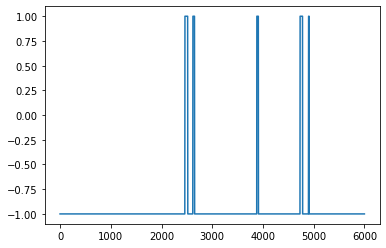

In [ ]:
plt.plot(flat_list[4000:10000])

Тестовые данные:

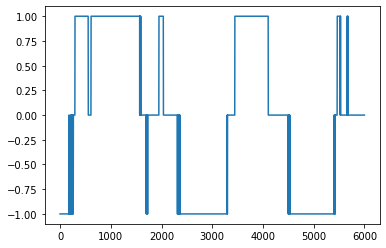

In [ ]:
plt.plot(y_test[4000:10000])

Сама траектория с потенциометра (добавляли ее в батчи, но не пускали в само обучение):

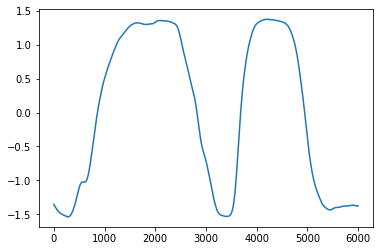

In [ ]:
plt.plot(traj[4000:10000])